In [ ]:
#importing necessary libraries
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
from os import listdir
import json
import re
import joblib
import tensorflow as tf
import os
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
from collections import defaultdict
from operator import itemgetter
import operator
from tensorflow.keras import utils
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU, add, Conv2D, Reshape
from tensorflow.keras.applications.vgg19 import preprocess_input
import pickle
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import datetime
from tensorflow.keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, multiply
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Downloading train and validation data and unzipping it
def download_vqa_data():
    Questions_Train_mscoco = tf.keras.utils.get_file('v2_Questions_Train_mscoco.zip',
                                      cache_subdir=os.path.abspath('/content/data'),
                                      origin = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip',
                                        extract = True)

    Questions_Val_mscoco = tf.keras.utils.get_file('v2_Questions_Val_mscoco.zip',
                                        cache_subdir=os.path.abspath('/content/data'),
                                        origin = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip',
                                        extract = True)

    Annotations_Train_mscoco = tf.keras.utils.get_file('v2_Annotations_Train_mscoco.zip',
                                        cache_subdir=os.path.abspath('/content/data'),
                                        origin = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip',
                                        extract = True)

    Annotations_Val_mscoco = tf.keras.utils.get_file('v2_Annotations_Val_mscoco.zip',
                                        cache_subdir=os.path.abspath('/content/data'),
                                        origin = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip',
                                        extract = True)
    os.remove(Questions_Train_mscoco)
    os.remove(Questions_Val_mscoco)
    os.remove(Annotations_Train_mscoco)
    os.remove(Annotations_Val_mscoco)

In [ ]:
download_vqa_data()

10518930/10518930 [==============================] - 2s 0us/step


In [ ]:
def getAllAnswer(answers_list):
	answers = []
	for i in range(len(answers_list)):
		answers.append(answers_list[i]['answer'])
	return ';'.join(answers)     

In [ ]:
def process_question_annotation(subset):
    anno = json.load(open(f'/content/data/v2_mscoco_{subset}_annotations.json', 'r'))
    ques = json.load(open(f'/content/data/v2_OpenEnded_mscoco_{subset}_questions.json', 'r'))
    imdir='%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    data = []

    for i in tqdm(range(len(anno['annotations']))):
        image_path = imdir%(subset, subset, anno['annotations'][i]['image_id'])
        question = ques['questions'][i]['question']
        answer = anno['annotations'][i]['multiple_choice_answer']
        
        answer_list = getAllAnswer(anno['annotations'][i]['answers'])

        data.append({'img_path': image_path, 'question': question, 'answer': answer, 'answer_list': answer_list})
    
    # save to disk
    json.dump(data, open(f'/content/drive/MyDrive/VQA/processed_files/vqa_raw_{subset}.json', 'w'))

In [ ]:
subset = ['train2014', 'val2014']
for x in subset:
    process_question_annotation(x)

100%|██████████| 214354/214354 [00:01<00:00, 154822.36it/s]


In [ ]:
train_data = json.load(open(f'/content/drive/MyDrive/VQA/processed_files/vqa_raw_train2014.json', 'r'))
val_data = json.load(open(f'/content/drive/MyDrive/VQA/processed_files/vqa_raw_val2014.json', 'r'))

In [ ]:
answer_freq= defaultdict(int)
for answer in list(map(itemgetter('answer'), train_data)):
		answer_freq[answer] += 1
print('There are total ', len(answer_freq), ' different types of answers.')

There are total  22531  different types of answers.


In [ ]:
max_answers = 2 

In [ ]:
def selectTopAnswersData(questions_list, answer_list, answers_list, images_list, k):
	answer_freq= defaultdict(int)

	for answer in answer_list:
		answer_freq[answer] += 1

	sorted_freq = sorted(answer_freq.items(), key=operator.itemgetter(1), reverse=True)[0: k]
	top_answers, top_freq = zip(*sorted_freq)
 
	new_questions_list=[]
	new_answer_list=[]
	new_answers_list=[]
	new_images_list=[]

	for question, answer, answers, image in zip(questions_list, answer_list, answers_list, images_list):
		if answer in top_answers:
			new_questions_list.append(question)
			new_answer_list.append(answer)
			new_answers_list.append(answers)
			new_images_list.append(image)
	
	print('Data size reduced by', np.round(((len(questions_list)-len(new_questions_list))/len(questions_list))*100, 2),'%')
	return(new_questions_list, new_answer_list, new_answers_list, new_images_list, top_answers)

In [ ]:
questions_train, answer_train, answers_train, images_train, top_answers = selectTopAnswersData(list(map(itemgetter('question'), train_data)), 
                                                                                               list(map(itemgetter('answer'), train_data)), 
                                                                                               list(map(itemgetter('answer_list'), train_data)), 
                                                                                               list(map(itemgetter('img_path'), train_data)), max_answers)

Data size reduced by 62.26 %


In [ ]:
def filterTopAnswersData(questions_list, answer_list, answers_list, images_list, top_answers):
	new_questions_list=[]
	new_answer_list=[]
	new_answers_list=[]
	new_images_list=[]

	for question, answer, answers, image in zip(questions_list, answer_list, answers_list, images_list):
		if answer in top_answers:
			new_questions_list.append(question)
			new_answer_list.append(answer)
			new_answers_list.append(answers)
			new_images_list.append(image)
	
	print('Data size reduced by', np.round(((len(questions_list)-len(new_questions_list))/len(questions_list))*100, 2),'%')
	return (new_questions_list, new_answer_list, new_answers_list, new_images_list)

In [ ]:
questions_val, answer_val, answers_val, images_val = filterTopAnswersData(list(map(itemgetter('question'), val_data)), 
                                                                          list(map(itemgetter('answer'), val_data)),
                                                                          list(map(itemgetter('answer_list'), val_data)), 
                                                                          list(map(itemgetter('img_path'), val_data)), top_answers)

Data size reduced by 62.3 %


In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/vqa_raw_train2014_top1000.json', 'wb') as f:
    joblib.dump((questions_train, answer_train, answers_train, images_train), f)
with open('/content/drive/MyDrive/VQA/processed_files/vqa_raw_val2014_top1000.json', 'wb') as f:
    joblib.dump((questions_val, answer_val, answers_val, images_val), f)    

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/vqa_raw_train2014_top1000.json', 'rb') as f:
  questions_train, answer_train, answers_train, images_train = joblib.load(f)

with open('/content/drive/MyDrive/VQA/processed_files/vqa_raw_val2014_top1000.json', 'rb') as f:
  questions_val, answer_val, answers_val, images_val = joblib.load(f)

In [ ]:
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    os.remove(image_zip)

13510573713/13510573713 [==============================] - 896s 0us/step


In [ ]:
val_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + val_folder):
    val_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/val2014.zip',
                                      extract = True)
    os.remove(val_zip)

6645013297/6645013297 [==============================] - 412s 0us/step


In [ ]:
def image_feature_extractor(target_path, image_list, BATCH_SIZE):
    model = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(3, 224, 224)))

      # add a progress bar
    #progbar = utils.Progbar(int(np.ceil(len(image_list) / float(BATCH_SIZE))))

      # loop over the images in batches
    for (b, i) in tqdm(enumerate(range(0, len(image_list), BATCH_SIZE))):
      # extract batch of images and prepare them to pass it through the VGG 
      # network for feature extraction
      #progbar.update(b+1)
      
      batch_range = range(i, min(i + BATCH_SIZE, len(image_list)))
      batchPaths = image_list[batch_range[0]: batch_range[-1]+1]

      batchImages = []
      batchIds = []
      # loop over the images and labels in the current batch
      for imagePath in batchPaths:

              # load the input image using the Keras helper utility
              # while ensuring the image is resized to 224x224 pixels
        img = image.load_img('train2014/'+imagePath, target_size=(224, 224))
        img = image.img_to_array(img)
      
              # preprocess the image by 
              # (1) expanding the dimensions to include batch dim and
              # (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
      
              # add the image to the batch
        batchImages.append(img)
        # image ids of the batch
        batchIds.append(imagePath.split('.')[0][-6:])
      
      batchImages = np.vstack(batchImages) # (BATCH_SIZE, 3, 224, 224)

      # pass the images through the network and use the outputs as our actual features
      features = model.predict(batchImages) # (BATCH_SIZE, 512, 7, 7)
      features = tf.reshape(features, (features.shape[0], features.shape[1], -1)) # (BATCH_SIZE, 512, 49)
      features = tf.transpose(features, perm =[0,2,1])  # (BATCH_SIZE, 49, 512)

      # loop over the batch to save them locally
      for id, feat in zip(batchIds, features):
        np.save(os.path.join(target_path, id), feat)     

In [ ]:
image_list = os.listdir('train2014')
BATCH_SIZE = 300
target_path = 'features'

In [ ]:
image_feature_extractor(target_path, image_list, BATCH_SIZE)

In [ ]:
import string
    
# Storing the sets of punctuation in variable result 
result = string.punctuation 
print(list(result))

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [ ]:
import re

def process_sentence(sentence):
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    commaStrip   = re.compile("(\d)(\,)(\d)")
    punct        = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', 
                    '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', 
                    '^', '_', '`', '{', '|', '}', '~']
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                    "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                    "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                    "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                    "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                    "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                    "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                    "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                    "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                    "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                    "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                    "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                    "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                    "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                    "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                    "youll": "you'll", "youre": "you're", "youve": "you've"}

    inText = sentence.replace('\n', ' ')
    inText = inText.replace('\t', ' ')
    inText = inText.strip()
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) or \
           (re.search(commaStrip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
    outText = periodStrip.sub("", outText, re.UNICODE)
    outText = outText.lower().split()
    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [ ]:
questions_train_processed = pd.Series(questions_train).apply(process_sentence)
questions_val_processed = pd.Series(questions_val).apply(process_sentence)

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/processed_questions.pkl', 'wb') as f:
    joblib.dump((questions_train_processed, questions_val_processed), f)

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/processed_questions.pkl', 'rb') as f:
    questions_train_processed, questions_val_processed = joblib.load(f)

In [ ]:
tok=text.Tokenizer(filters='')
tok.fit_on_texts(questions_train_processed)

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/text_tokenizer.pkl', 'wb') as f:
    joblib.dump(tok, f)

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/text_tokenizer.pkl', 'rb') as f:
    tok = joblib.load(f)

In [ ]:
question_data_train = tok.texts_to_sequences(questions_train_processed)
question_data_val = tok.texts_to_sequences(questions_val_processed)

In [ ]:
for i in range(0,11):
    print(10*i,'percentile value is', np.percentile(question_len,10*i))

0 percentile value is 2.0
10 percentile value is 4.0
20 percentile value is 4.0
30 percentile value is 5.0
40 percentile value is 5.0
50 percentile value is 6.0
60 percentile value is 6.0
70 percentile value is 7.0
80 percentile value is 7.0
90 percentile value is 8.0
100 percentile value is 22.0


In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(question_len,90+i))
     

90 percentile value is 8.0
91 percentile value is 8.0
92 percentile value is 9.0
93 percentile value is 9.0
94 percentile value is 9.0
95 percentile value is 9.0
96 percentile value is 10.0
97 percentile value is 10.0
98 percentile value is 11.0
99 percentile value is 12.0
100 percentile value is 22.0


In [ ]:
MAX_LEN = 22

In [ ]:
question_data_train=sequence.pad_sequences(question_data_train, maxlen=MAX_LEN, padding='post')
question_data_val=sequence.pad_sequences(question_data_val, maxlen=MAX_LEN, padding = 'post')

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/tokenised_data_post.pkl', mode='wb') as f:
    pickle.dump((question_data_train, question_data_val), f)

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/tokenised_data_post.pkl', mode='rb') as f:
    question_data_train, question_data_val = pickle.load(f)

In [ ]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(answer_train)

LabelEncoder()

In [ ]:
#only 2 classes -'yes','no'
len(labelencoder.classes_)

2

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/labelencoder.pkl', 'wb') as f:
    joblib.dump(labelencoder, f)  

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/labelencoder.pkl', 'rb') as f:
    labelencoder = joblib.load(f)

In [ ]:
def get_answers_matrix(answers, encoder):
	y = encoder.transform(answers) #string to numerical class
	nb_classes = encoder.classes_.shape[0]
	Y = utils.to_categorical(y, nb_classes)
	return Y     

#Train-validation split

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size= 0.25,random_state=42)

for train_index, val_index in sss.split(images_train, answer_train):
  TRAIN_INDEX = train_index
  VAL_INDEX = val_index    

In [ ]:
image_list_tr, image_list_vl = np.array(images_train)[TRAIN_INDEX.astype(int)], np.array(images_train)[VAL_INDEX.astype(int)]

In [ ]:
question_tr, question_vl = question_data_train[TRAIN_INDEX], question_data_train[VAL_INDEX]

In [ ]:
answer_matrix = get_answers_matrix(answer_train, labelencoder)
answer_tr, answer_vl = answer_matrix[TRAIN_INDEX], answer_matrix[VAL_INDEX]

In [ ]:
print(image_list_tr)

['train2014/COCO_train2014_000000376407.jpg'
 'train2014/COCO_train2014_000000481354.jpg'
 'train2014/COCO_train2014_000000363848.jpg' ...
 'train2014/COCO_train2014_000000484341.jpg'
 'train2014/COCO_train2014_000000173367.jpg'
 'train2014/COCO_train2014_000000548644.jpg']


#Dataset

In [ ]:
BATCH_SIZE = 300
BUFFER_SIZE = 5000

In [ ]:
#Images are converted to numpy arrays
def map_func(img_name, ques):
    img_tensor = np.load('/content/features/' + img_name.decode('utf-8').split('.')[0][-6:] + '.npy')
    return img_tensor, ques

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_list_tr, question_tr))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_train_dataset = tf.data.Dataset.from_tensor_slices(answer_tr)
train_dataset   = tf.data.Dataset.zip((train_dataset,op_train_dataset))
train_dataset = train_dataset.batch(1000)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_list_vl, question_vl))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_test_dataset = tf.data.Dataset.from_tensor_slices(answer_vl)
test_dataset=tf.data.Dataset.zip((test_dataset,op_test_dataset))
test_dataset = test_dataset.batch(1000)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
max_answers = 2
max_seq_len = 22
vocab_size  = len(tok.word_index) + 1

#Baseline Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
base_input1 = Input(shape=(49, 512, ), name='Image_Input') #Input shape
x1 = tf.keras.layers.Flatten()(base_input1) 
base_output1= tf.keras.layers.Dense(1024,activation='relu')(x1)
image_model=Model(inputs=base_input1,outputs=base_output1)
image_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 49, 512)]         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
Total params: 25,691,136
Trainable params: 25,691,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_input2 = Input(shape=(22, ), name='Question_Input')
embed2        = tf.keras.layers.Embedding(vocab_size, 200, input_length=max_seq_len)(base_input2)
l1            = tf.compat.v1.keras.layers.CuDNNLSTM(128,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1(0.001),return_sequences=True)(embed2)
lstm22        = tf.compat.v1.keras.layers.CuDNNLSTM(256,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1(0.001),return_sequences=True)(l1)
flat1         = tf.keras.layers.Flatten()(lstm22)
base_output2  = tf.keras.layers.Dense(1024,activation='relu',kernel_initializer='he_normal')(flat1)
question_model = Model(inputs=base_input2, outputs=base_output2)
question_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Question_Input (InputLayer)  [(None, 22)]             0         
                                                                 
 embedding (Embedding)       (None, 22, 200)           2075600   
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 22, 128)           168960    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 22, 256)           395264    
                                                                 
 flatten_1 (Flatten)         (None, 5632)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5768192   
                                                                 
Total params: 8,408,016
Trainable params: 8,408,016
Non-tra

In [ ]:
combined_output   = tf.keras.layers.Multiply()([image_model.layers[-1].output,question_model.layers[-1].output])
drop                = tf.keras.layers.Dropout(0.3)(combined_output)
final_base_output = tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_normal')(drop)
bn                = tf.keras.layers.BatchNormalization()(final_base_output) #to reduce overfitting
final_output      = tf.keras.layers.Dense(2,activation='softmax')(bn) #to reduce overfitting
final_model       = tf.keras.Model(inputs=[base_input1,base_input2],outputs=final_output)
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Question_Input (InputLayer)    [(None, 22)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 22, 200)      2075600     ['Question_Input[0][0]']         
                                                                                                  
 cu_dnnlstm (CuDNNLSTM)         (None, 22, 128)      168960      ['embedding[0][0]']              
                                                                                                  
 Image_Input (InputLayer)       [(None, 49, 512)]    0           []                               
                                                                                            

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("baseline_model.h5",monitor="val_accuracy",mode="max",save_best_only = True,verbose=1)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)

In [ ]:
final_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
final_model.fit(train_dataset, epochs=10, verbose=1, validation_data=test_dataset, callbacks=[tensorboard,checkpoint,earlystop])

Epoch 1/10
126/126 [==============================] - ETA: 0s - loss: 12.1888 - accuracy: 0.5174
Epoch 1: val_accuracy improved from -inf to 0.52904, saving model to baseline_model.h5
126/126 [==============================] - 97s 761ms/step - loss: 12.1888 - accuracy: 0.5174 - val_loss: 4.6658 - val_accuracy: 0.5290
Epoch 2/10
126/126 [==============================] - ETA: 0s - loss: 2.1029 - accuracy: 0.5458
Epoch 2: val_accuracy improved from 0.52904 to 0.53804, saving model to baseline_model.h5
126/126 [==============================] - 95s 753ms/step - loss: 2.1029 - accuracy: 0.5458 - val_loss: 0.8656 - val_accuracy: 0.5380
Epoch 3/10
126/126 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.5643
Epoch 3: val_accuracy did not improve from 0.53804
126/126 [==============================] - 94s 746ms/step - loss: 0.7415 - accuracy: 0.5643 - val_loss: 0.7285 - val_accuracy: 0.5366
Epoch 4/10
126/126 [==============================] - ETA: 0s - loss: 0.6970 - a

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fits

#BERT

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.1 MB/s 
     |████████████████████████████████| 7.6 MB 64.1 MB/s 
     |████████████████████████████████| 182 kB 78.0 MB/s 


In [ ]:
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

In [ ]:
#distilert uncased model doesn't differentiate between capital and small letters i.e change in word case
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


##Creating Dataset

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/dbert_tokenizer.pkl', 'rb') as f:
    dbert_tokenizer = joblib.load(f)

In [ ]:
max_len=22
sentences=questions_train_processed
len(sentences)

167494

In [ ]:
train_sentences=questions_train_processed
test_sentences = questions_val_processed
max_len = 22

In [ ]:
#words are encoded to max length with [CLS] and [SEP] and [PAD] tokens
train_tokens, test_tokens=[],[]
train_attention_masks,test_attention_masks=[],[]

for sent in tqdm(train_sentences):
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,\
                                           max_length =max_len,pad_to_max_length = True,\
                                           return_attention_mask = True,truncation=True)
    train_tokens.append(dbert_inps['input_ids'])
    train_attention_masks.append(dbert_inps['attention_mask'])

train_tokens=np.asarray(train_tokens)
train_attention_masks=np.array(train_attention_masks)

for sent in tqdm(test_sentences):
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,\
                                           max_length =max_len, pad_to_max_length = True,\
                                           return_attention_mask = True,truncation=True)
    test_tokens.append(dbert_inps['input_ids'])
    test_attention_masks.append(dbert_inps['attention_mask'])

test_tokens=np.asarray(test_tokens)
test_attention_masks=np.array(test_attention_masks)

100%|██████████| 80810/80810 [00:19<00:00, 4236.76it/s]


In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/dbert_tokenizer.pkl', 'wb') as f:
    joblib.dump(dbert_tokenizer, f)

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/dbert_tokenizer.pkl', 'rb') as f:
    dbert_tokenizer = joblib.load(f)    

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/bert_tokens.pkl', mode='wb') as f:
    pickle.dump((train_tokens, test_tokens), f)

In [ ]:
with open('/content/drive/MyDrive/VQA/processed_files/bert_tokens.pkl', mode='rb') as f:
    train_tokens, test_tokens = pickle.load(f)

In [ ]:
question_tr_tokens, question_vl_tokens = train_tokens[TRAIN_INDEX], train_tokens[VAL_INDEX]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_list_tr, question_tr_tokens))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_train_dataset = tf.data.Dataset.from_tensor_slices(answer_tr)
train_dataset   = tf.data.Dataset.zip((train_dataset,op_train_dataset))
train_dataset = train_dataset.batch(500)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_list_vl, question_vl_tokens))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_test_dataset = tf.data.Dataset.from_tensor_slices(answer_vl)
test_dataset=tf.data.Dataset.zip((test_dataset,op_test_dataset))
test_dataset = test_dataset.batch(500)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##Model Architecture and Training

In [ ]:
for layer in dbert_model.layers:
    layer.trainable = False

In [ ]:
#Model architecture
ques_input = tf.keras.layers.Input(shape = (22,), name='Question_Input',dtype=tf.int64)
dbert_layer = dbert_model(ques_input)
conv1D = tf.keras.layers.Conv1D(filters=5, kernel_size=10)(dbert_layer.last_hidden_state)      
pooling = tf.keras.layers.MaxPooling1D(pool_size=3)(conv1D)
flat1 = tf.keras.layers.Flatten()(pooling)
base_output1  = tf.keras.layers.Dense(128,activation='relu',kernel_initializer='he_normal')(flat1)

img_input  = tf.keras.layers.Input(shape=(49, 512, ), name='Image_Input')
conv1D_2 = tf.keras.layers.Conv1D(filters=5, kernel_size=10)(img_input)      
pooling2 = tf.keras.layers.MaxPooling1D(pool_size=3)(conv1D_2)
flat2 = tf.keras.layers.Flatten()(pooling2)
base_output2  = tf.keras.layers.Dense(128,activation='relu',kernel_initializer='he_normal')(flat2)

combined_output   = tf.keras.layers.Multiply()([base_output2,base_output1])
drop                = tf.keras.layers.Dropout(0.1)(combined_output)
bn                = tf.keras.layers.BatchNormalization()(drop)
final_base_output = tf.keras.layers.Dense(128,activation='relu',kernel_initializer='he_normal')(bn)
final_output      = tf.keras.layers.Dense(2,activation='softmax')(final_base_output)
model = tf.keras.Model(inputs=[img_input,ques_input], outputs=final_output)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Question_Input (InputLayer)    [(None, 22)]         0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 49, 512)]    0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['Question_Input[0][0]']         
 BertModel)                     ast_hidden_state=(N                                               
                                one, 22, 768),                                                    
                                 hidden_states=None                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("bert_model1.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

%load_ext tensorboard
import datetime
!rm -rf ./logs/ 
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)

callbacks = [checkpoint,tensorboard]

In [ ]:
model.fit(train_dataset, epochs=10, verbose=1,validation_data=test_dataset,callbacks=callbacks, batch_size=128)
#if OOM error occurs, reduce batch size(reduced from 1000 to 500)

Epoch 1/10
252/252 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.5136
Epoch 1: val_accuracy improved from -inf to 0.52297, saving model to bert_model1.h5
252/252 [==============================] - 245s 935ms/step - loss: 0.7283 - accuracy: 0.5136 - val_loss: 0.7170 - val_accuracy: 0.5230
Epoch 2/10
252/252 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.5287
Epoch 2: val_accuracy improved from 0.52297 to 0.53157, saving model to bert_model1.h5
252/252 [==============================] - 232s 918ms/step - loss: 0.6977 - accuracy: 0.5287 - val_loss: 0.7005 - val_accuracy: 0.5316
Epoch 3/10
252/252 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5381
Epoch 3: val_accuracy did not improve from 0.53157
252/252 [==============================] - 227s 899ms/step - loss: 0.6920 - accuracy: 0.5381 - val_loss: 0.6986 - val_accuracy: 0.5316
Epoch 4/10
252/252 [==============================] - ETA: 0s - loss: 0.6908 - accura

In [ ]:
model.save('/content/drive/MyDrive/saved_model/trained_bert_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
custom_objects = {"TFDistilBertModel": TFDistilBertModel}
bert_model = load_model('/content/drive/MyDrive/saved_model/trained_bert_model.h5',custom_objects=custom_objects)

In [ ]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
bert_model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

#Evaluation

In [ ]:
#Actual train and validation data is listed here
df_train = pd.DataFrame(list(zip(questions_train, answer_train, images_train)),\
                  columns =['questions_train', 'answer_train','images_train'])

In [ ]:
df_test = pd.DataFrame(list(zip(questions_val, answer_val, images_val)),\
                  columns =['questions_val', 'answer_val','images_val'])

In [ ]:
def image_feature_extractor(image_file, model):
  img = image.load_img(image_file, target_size=(224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  features = model.predict(img) # (BATCH_SIZE, 512, 7, 7)
  features = tf.reshape(features, (features.shape[0], features.shape[1], -1))
  features = tf.transpose(features, perm =[0,2,1])  # (BATCH_SIZE, 49, 512)
  return features

In [ ]:
def predict_answers(img_feat, ques_feat, model, labelencoder):
    preds = model([img_feat, ques_feat])
    y_classes = tf.argmax(preds, axis=1, output_type=tf.int32)
    y_predict = (labelencoder.inverse_transform(y_classes))
    return y_predict

In [ ]:
vgg_model = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(3, 224, 224)))

80134624/80134624 [==============================] - 4s 0us/step


###Test Images

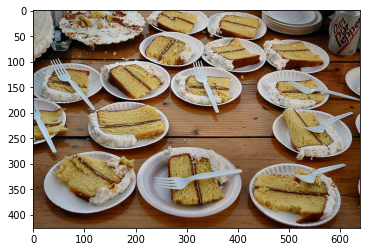

1/1 [==============================] - 0s 18ms/step
Question         : Is there enough forks available?
Expected answer  : no
Predicted answer : no


In [ ]:
sample_img = df_test['images_val'][5690]
actual_answer = df_test['answer_val'][5690]
question = df_test['questions_val'][5690]
im = Image.open(sample_img)
plt.imshow(im)
plt.show()
image_data = image_feature_extractor(sample_img,vgg_model)
question_processed = pd.Series(question).apply(process_sentence)
dbert_inps = dbert_tokenizer.encode_plus(question_processed[0],add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
test_token=np.asarray(dbert_inps['input_ids'])  
y_predict = predict_answers(image_data, test_token, bert_model, labelencoder)
print('Question         :',question)
print('Expected answer  :',actual_answer)
print('Predicted answer :',y_predict[0])

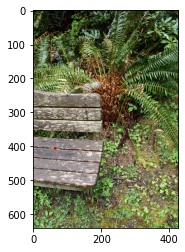

1/1 [==============================] - 0s 19ms/step
Question         : Is this bench old?
Expected answer  : yes
Predicted answer : yes


In [ ]:
sample_img = df_test['images_val'][78345]
actual_answer = df_test['answer_val'][78345]
question = df_test['questions_val'][78345]
im = Image.open(sample_img)
plt.imshow(im)
plt.show()
image_data = image_feature_extractor(sample_img,vgg_model)
question_processed = pd.Series(question).apply(process_sentence)
dbert_inps = dbert_tokenizer.encode_plus(question_processed[0],add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
test_token=np.asarray(dbert_inps['input_ids'])  
y_predict = predict_answers(image_data, test_token, bert_model, labelencoder)
print('Question         :',question)
print('Expected answer  :',actual_answer)
print('Predicted answer :',y_predict[0])

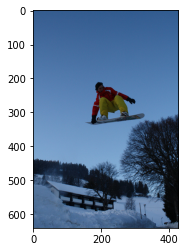

1/1 [==============================] - 0s 22ms/step
Question         : Is this a beach scene?
Expected answer  : no
Predicted answer : yes


In [ ]:
sample_img = df_test['images_val'][56]
actual_answer = df_test['answer_val'][56]
question = df_test['questions_val'][56]
im = Image.open(sample_img)
plt.imshow(im)
plt.show()
image_data = image_feature_extractor(sample_img,vgg_model)
question_processed = pd.Series(question).apply(process_sentence)
dbert_inps = dbert_tokenizer.encode_plus(question_processed[0],add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
test_token=np.asarray(dbert_inps['input_ids'])  
y_predict = predict_answers(image_data, test_token, bert_model, labelencoder)
print('Question         :',question)
print('Expected answer  :',actual_answer)
print('Predicted answer :',y_predict[0])